# Bases de Datos II. NoSQL (MongoDB sesión 3)

```
                                                                  ,gggggggggggg,    ,ggggggggggg,  
                                                                 dP"""88""""""Y8b, dP"""88""""""Y8,
                                                                 Yb,  88       `8b,Yb,  88      `8b
                                                                  `"  88        `8b `"  88      ,8P
                                                                      88         Y8     88aaaad8P"
  ,ggg,,ggg,,ggg,     ,ggggg,    ,ggg,,ggg,     ,gggg,gg    ,ggggg,   88         d8     88""""Y8ba
 ,8" "8P" "8P" "8,   dP"  "Y8ggg,8" "8P" "8,   dP"  "Y8I   dP"  "Y8ggg88        ,8P     88      `8b
 I8   8I   8I   8I  i8'    ,8I  I8   8I   8I  i8'    ,8I  i8'    ,8I  88       ,8P'     88      ,8P
,dP   8I   8I   Yb,,d8,   ,d8' ,dP   8I   Yb,,d8,   ,d8I ,d8,   ,d8'  88______,dP'      88_____,d8'
8P'   8I   8I   `Y8P"Y8888P"   8P'   8I   `Y8P"Y8888P"888P"Y8888P"   888888888P"       88888888P"  
                                                    ,d8I'                                          
                                                  ,dP'8I                                           
                                                 ,8"  8I                                           
                                                 I8   8I                                           
                                                 `8, ,8I                                           
                                                  `Y8P"                             
                                                  
                                                                 
                                             ______
|_  _  _  _  _     _| _     _| _ _|_ _  _     |  |
|_)(_|_> (/__>    (_|(/_   (_|(_| |_(_)_>    _|__|_
```


![MongoDB](https://webassets.mongodb.com/_com_assets/cms/MongoDB_Logo_FullColorBlack_RGB-4td3yuxzjs.png)

Esta hoja es la tercera entrega y última del trabajo con MongoDB. Veremos temas avanzados como cálculos `aggregate()` más complejos, el uso de índices, etc. Al final habrá un conjunto de ejercicios que habrá que resolver y entregar en la tarea abierta para la ocasión.

## Inicio de la hoja


In [2]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False

In [3]:
!wget -qO - https://www.mongodb.org/static/pgp/server-6.0.asc | sudo gpg --dearmor > /etc/apt/trusted.gpg.d/mongo-server-6.gpg

In [4]:
%%bash
sudo adduser --system --no-create-home mongodb
sudo addgroup --system mongodb
sudo adduser mongodb mongodb

# create db -- note: this should agree with dbpath in mongod.conf
if [ ! -d /var/lib/mongodb ]; then
  sudo mkdir -p /var/lib/mongodb
  sudo chown mongodb:mongodb /var/lib/mongodb
fi

# create logdir -- note: this should agree with logpath in mongod.conf
if [ ! -d /var/log/mongodb ]; then
  sudo mkdir -p /var/log/mongodb
  sudo chown mongodb:mongodb /var/log/mongodb
fi

Adding system user `mongodb' (UID 104) ...
Adding new user `mongodb' (UID 104) with group `nogroup' ...
Not creating home directory `/home/mongodb'.
Adding group `mongodb' (GID 107) ...
Done.
Adding user `mongodb' to group `mongodb' ...
Adding user mongodb to group mongodb
Done.


In [5]:
!echo "deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse" | sudo tee /etc/apt/sources.list.d/mongodb-org-6.0.list

deb [ arch=amd64,arm64 ] https://repo.mongodb.org/apt/ubuntu jammy/mongodb-org/6.0 multiverse


In [6]:
!sudo apt-get update -qq

In [7]:
!sudo ln -sf /bin/true /bin/systemctl

In [8]:
!sudo apt-get install -y -qq dialog mongodb-org

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 10.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package dialog.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../0-dialog_1.3-20211214-1_amd64.deb ...
Unpacking dialog (1.3-20211214-1) ...
Selecting previously unselected package mongodb-database-tools.
Preparing to unpack .../1-mongodb-database-tools_100.9.4_amd64.deb ...
Unpacking mongodb-database-tools (100.9.4) ...
Selecting previously unselected package mongodb-mongosh.
Preparing to unpack .../2-mongodb-mongosh_2.1.5_amd64.deb ...
Unpacking mongodb-mongosh (2

In [9]:
!sudo /usr/bin/mongod --config /etc/mongod.conf --fork

about to fork child process, waiting until server is ready for connections.
forked process: 1702
child process started successfully, parent exiting


In [10]:
!sudo mongod --version

db version v6.0.14
Build Info: {
    "version": "6.0.14",
    "gitVersion": "25225db95574916fecab3af75b184409f8713aef",
    "openSSLVersion": "OpenSSL 3.0.2 15 Mar 2022",
    "modules": [],
    "allocator": "tcmalloc",
    "environment": {
        "distmod": "ubuntu2204",
        "distarch": "x86_64",
        "target_arch": "x86_64"
    }
}


In [11]:
!pip install --upgrade pymongo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.2/677.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 14.3 MB/s eta 0:00:00


In [12]:
from pprint import pprint as pp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.style.use('ggplot')

Usaremos la librería `pymongo` para python. La cargamos a continuación.

In [13]:
import pymongo
from pymongo import MongoClient

La conexión se inicia con `MongoClient` en el `host` descrito en el fichero `docker-compose.yml` (`mongo`), o bien a `localhost` si lo estamos haciendo en Colab.

In [14]:
db_hostname = "localhost" if RunningInCOLAB else "mongo"

In [15]:
client = MongoClient(db_hostname,27017)
client

MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True)

In [16]:
client.list_database_names()

['admin', 'config', 'local']

 - Format: 7zipped
 - Files:
   - **badges**.xml
       - UserId, e.g.: "420"
       - Name, e.g.: "Teacher"
       - Date, e.g.: "2008-09-15T08:55:03.923"
   - **comments**.xml
       - Id
       - PostId
       - Score
       - Text, e.g.: "@Stu Thompson: Seems possible to me - why not try it?"
       - CreationDate, e.g.:"2008-09-06T08:07:10.730"
       - UserId
   - **posts**.xml
       - Id
       - PostTypeId
          - 1: Question
          - 2: Answer
       - ParentID (only present if PostTypeId is 2)
       - AcceptedAnswerId (only present if PostTypeId is 1)
       - CreationDate
       - Score
       - ViewCount
       - Body
       - OwnerUserId
       - LastEditorUserId
       - LastEditorDisplayName="Jeff Atwood"
       - LastEditDate="2009-03-05T22:28:34.823"
       - LastActivityDate="2009-03-11T12:51:01.480"
       - CommunityOwnedDate="2009-03-11T12:51:01.480"
       - ClosedDate="2009-03-11T12:51:01.480"
       - Title=
       - Tags=
       - AnswerCount
       - CommentCount
       - FavoriteCount
   - **posthistory**.xml
	   - Id
	   - PostHistoryTypeId
			- 1: Initial Title - The first title a question is asked with.
			- 2: Initial Body - The first raw body text a post is submitted with.
			- 3: Initial Tags - The first tags a question is asked with.
			- 4: Edit Title - A question's title has been changed.
			- 5: Edit Body - A post's body has been changed, the raw text is stored here as markdown.
			- 6: Edit Tags - A question's tags have been changed.
			- 7: Rollback Title - A question's title has reverted to a previous version.
			- 8: Rollback Body - A post's body has reverted to a previous version - the raw text is stored here.
			- 9: Rollback Tags - A question's tags have reverted to a previous version.
			- 10: Post Closed - A post was voted to be closed.
			- 11: Post Reopened - A post was voted to be reopened.
			- 12: Post Deleted - A post was voted to be removed.
			- 13: Post Undeleted - A post was voted to be restored.
			- 14: Post Locked - A post was locked by a moderator.
			- 15: Post Unlocked - A post was unlocked by a moderator.
			- 16: Community Owned - A post has become community owned.
			- 17: Post Migrated - A post was migrated.
			- 18: Question Merged - A question has had another, deleted question merged into itself.
			- 19: Question Protected - A question was protected by a moderator
			- 20: Question Unprotected - A question was unprotected by a moderator
			- 21: Post Disassociated - An admin removes the OwnerUserId from a post.
			- 22: Question Unmerged - A previously merged question has had its answers and votes restored.
		- PostId
		- RevisionGUID: At times more than one type of history record can be recorded by a single action.  All of these will be grouped using the same RevisionGUID
		- CreationDate: "2009-03-05T22:28:34.823"
		- UserId
		- UserDisplayName: populated if a user has been removed and no longer referenced by user Id
		- Comment: This field will contain the comment made by the user who edited a post
		- Text: A raw version of the new value for a given revision
			- If PostHistoryTypeId = 10, 11, 12, 13, 14, or 15  this column will contain a JSON encoded string with all users who have voted for the PostHistoryTypeId
			- If PostHistoryTypeId = 17 this column will contain migration details of either "from <url>" or "to <url>"
		- CloseReasonId
			- 1: Exact Duplicate - This question covers exactly the same ground as earlier questions on this topic; its answers may be merged with another identical question.
			- 2: off-topic
			- 3: subjective
			- 4: not a real question
			- 7: too localized
   - **postlinks**.xml
     - Id
     - CreationDate
     - PostId
     - RelatedPostId
     - PostLinkTypeId
       - 1: Linked
       - 3: Duplicate
   - **users**.xml
     - Id
     - Reputation
     - CreationDate
     - DisplayName
     - EmailHash
     - LastAccessDate
     - WebsiteUrl
     - Location
     - Age
     - AboutMe
     - Views
     - UpVotes
     - DownVotes
   - **votes**.xml
     - Id
     - PostId
     - VoteTypeId
        - ` 1`: AcceptedByOriginator
        - ` 2`: UpMod
        - ` 3`: DownMod
        - ` 4`: Offensive
        - ` 5`: Favorite - if VoteTypeId = 5 UserId will be populated
        - ` 6`: Close
        - ` 7`: Reopen
        - ` 8`: BountyStart
        - ` 9`: BountyClose
        - `10`: Deletion
        - `11`: Undeletion
        - `12`: Spam
        - `13`: InformModerator
     - CreationDate
     - UserId (only for VoteTypeId 5)
     - BountyAmount (only for VoteTypeId 9)

Descargamos los ficheros CSV del repositorio de datos y los descomprimimos.

In [17]:
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001
!wget https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.002

--2024-03-06 19:23:48--  https://github.com/dsevilla/bd2-data/raw/main/es.stackoverflow/es.stackoverflow.csv.7z.001
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dsevilla/bd2-data/main/es.stackoverflow/es.stackoverflow.csv.7z.001 [following]
--2024-03-06 19:23:48--  https://raw.githubusercontent.com/dsevilla/bd2-data/main/es.stackoverflow/es.stackoverflow.csv.7z.001
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 104857600 (100M) [application/octet-stream]
Saving to: ‘es.stackoverflow.csv.7z.001’

es.stackoverflow.cs 100%[===================>] 100.00M   238MB/s    in 0.4s    

2024-03-06 19:23

In [18]:
!7zr x es.stackoverflow.csv.7z.001


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 104857600 bytes (100 MiB)

Extracting archive: es.stackoverflow.csv.7z.001
  0% 1 Open           --
Path = es.stackoverflow.csv.7z.001
Type = Split
Physical Size = 104857600
Volumes = 2
Total Physical Size = 200457538
----
Path = es.stackoverflow.csv.7z
Size = 200457538
--
Path = es.stackoverflow.csv.7z
Type = 7z
Physical Size = 200457538
Headers Size = 248
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% - Comments.csv                     1% - Comments.csv                     2% - Comments.csv                     3% - Comments.csv                 

In [19]:
!head Users.csv

Id,AboutMe,AccountId,CreationDate,DisplayName,DownVotes,LastAccessDate,Location,Reputation,UpVotes,Views,WebsiteUrl
-1,"<p>Hola, no soy una persona real.</p><br/><br/><p>¡Soy un proceso que ayuda a mantener el sitio limpio!</p><br/><br/><p>Hago cosas como:</p><br/><br/><ul><br/><li>Dar empujoncitos a preguntas antiguas sin respuesta aproximadamente cada hora, para que atraigan algo de atención.</li><br/><li>Tener la propiedad de las preguntas y respuestas wiki para que nadie se lleve reputación por ellas</li><br/><li>Recibir la propiedad de los votos negativos en las publicaciones de spam o dañinas que son borradas permanentemente</li><br/><li>Tener la propiedad de las ediciones sugeridas por usuarios anónimos</li><br/><li><a href=""http://meta.stackoverflow.com/a/92006"">Quitar preguntas abandonadas</a></li><br/></ul><br/>",-1,2015-10-26T21:36:24.767,Comunidad,22504,2015-10-26T21:36:24.767,en la granja de servidores,1,10211,2516,
1,"<p>Dev #2 who helped create Stack Overflow currently

Las bases de datos se crean conforme se nombran. Se puede utilizar la notación punto o la de diccionario. Las colecciones también.

In [20]:
db = client.stackoverflow
db = client['stackoverflow']
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow')

Las bases de datos están compuestas por un conjunto de **colecciones**. Cada colección aglutina a un conjunto de objetos (documentos) del mismo tipo, aunque como vimos en teoría, cada documento puede tener un conjunto de atributos diferente.

In [21]:
posts = db.posts
posts

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'stackoverflow'), 'posts')

Importación de los ficheros CSV. Por ahora creamos una colección diferente para cada uno. Después estudiaremos cómo poder optimizar el acceso usando agregación.

In [22]:
from urllib.request import urlretrieve

user = "dsevilla"
repo = "bd2-public"
src_dir = "util"
pyfile = "csv_to_mongo.py"
course="23-24"

url = f"https://raw.githubusercontent.com/{user}/{repo}/{course}/{src_dir}/{pyfile}"
urlretrieve(url, filename='csv_to_mongo.py')

('csv_to_mongo.py', <http.client.HTTPMessage at 0x7a8065211d50>)

In [23]:
!cat csv_to_mongo.py

import csv
import sys
from datetime import datetime
from tqdm.notebook import tqdm

def csv_to_mongo(file, coll):
    """
    Carga un fichero CSV en Mongo. file especifica el fichero, coll la colección
    dentro de la base de datos.
    """
    # Convertir todos los elementos que se puedan a números
    def to_numeric(d):
        if len(d) == 0:
            return ''
        if not ((d[0] >= '0' and d[0] <= '9') or d[0] == '-' or d[0] == '+' or d[0]=='.'):
            return str(d)
        try:
            return int(d) if abs(int(d)) <= sys.maxsize else str(d) # avoid mongo errors with big integers
        except ValueError:
            try:
                return float(d)
            except ValueError:
                return str(d)

    def to_date(d):
        """To ISO Date. If this cannot be converted, return NULL (None)"""
        try:
            return datetime.strptime(d, "%Y-%m-%dT%H:%M:%S.%f")
        except ValueError:
            return None

    def to_str(d):
        tr

In [24]:
import csv_to_mongo
help(csv_to_mongo)

Help on module csv_to_mongo:

NAME
    csv_to_mongo

FUNCTIONS
    csv_to_mongo(file, coll)
        Carga un fichero CSV en Mongo. file especifica el fichero, coll la colección
        dentro de la base de datos.

FILE
    /content/csv_to_mongo.py




In [25]:
csv_to_mongo.csv_to_mongo('Posts.csv',db.posts)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

In [26]:
csv_to_mongo.csv_to_mongo('Users.csv',db.users)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

In [27]:
csv_to_mongo.csv_to_mongo('Votes.csv',db.votes)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

In [28]:
csv_to_mongo.csv_to_mongo('Comments.csv',db.comments)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

In [29]:
csv_to_mongo.csv_to_mongo('Tags.csv',db.tags)

Leyendo e insertando filas...: 0it [00:00, ?it/s]

In [30]:
posts.count_documents({})

410346

### El API de colección de MongoDB

El API de colección en Python se puede encontrar aquí: https://docs.mongodb.com/drivers/pymongo/. La mayoría de libros y referencias muestran el uso de mongo desde Javascript, ya que el *shell* de MongoDB acepta ese lenguaje. La sintaxis con respecto a Python cambia un poco, y se puede seguir en el enlace anterior. Existe incluso un curso de la MongoDB University que se puede realizar de forma gratuita: https://learn.mongodb.com/learning-paths/using-mongodb-with-python

## Framework de Agregación

Framework de agregación:
- Aquí está la referencia de las diferentes etapas por las que puede pasar un pipeline: https://www.mongodb.com/docs/manual/reference/operator/aggregation-pipeline/.
- Y aquí los distintos operadores que se permiten dentro de las etapas: https://docs.mongodb.com/manual/reference/operator/aggregation/.
- Y aquí incluso un libro completo con usos prácticos de ejecutar agregación: https://www.practical-mongodb-aggregations.com/.

A continuación otro vídeo interseante:

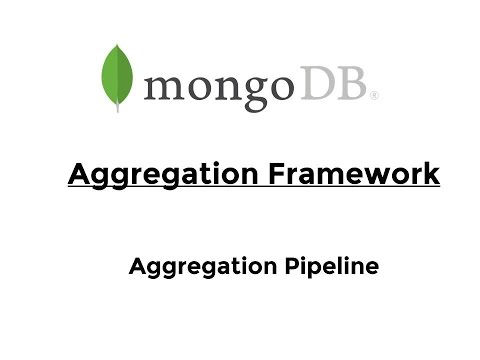

In [31]:
from IPython.display import YouTubeVideo
YouTubeVideo('VSX4a3h4SmQ',width=600)

![](https://miro.medium.com/max/1060/1*2lDBxvZ8Cr3JYkoODTa0lQ.png)

Proyección:

In [32]:
respuestas = db['posts'].aggregate( [
    {'$project' : { 'Id' : True }},
    {'$limit': 20} ])
list(respuestas)

[{'_id': ObjectId('65e8c2e9a93f2fcd7752bae6'), 'Id': 1},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bae7'), 'Id': 2},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bae8'), 'Id': 3},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bae9'), 'Id': 4},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baea'), 'Id': 5},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baeb'), 'Id': 6},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baec'), 'Id': 7},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baed'), 'Id': 8},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baee'), 'Id': 9},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baef'), 'Id': 10},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baf0'), 'Id': 11},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baf1'), 'Id': 12},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baf2'), 'Id': 14},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baf3'), 'Id': 15},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baf4'), 'Id': 16},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baf5'), 'Id': 17},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752baf6'), 'Id': 18},
 {'_id': ObjectId('65e8

_Lookup_!

In [33]:
respuestas = posts.aggregate( [
        {'$match': { 'Score' : {'$gte': 40}}},
        {'$limit' : 50},
        {'$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"}
        }
        ])
list(respuestas)

[{'_id': ObjectId('65e8c2e9a93f2fcd7752bae6'),
  'Id': 1,
  'AcceptedAnswerId': 2,
  'AnswerCount': 1,
  'Body': '<p>Estoy creando un servicio usando <em>ASP.NET WebApi</em>. Quiero añadir soporte para la negociación del tipo de contenido basado en extensiones en el <em>URI</em>, así que he añadido lo siguiente al código de inicialización del servicio:</p><br/><br/><pre><code>public static class WebApiConfig<br/>{<br/>  public static void Register(HttpConfiguration config)<br/>  {<br/>    config.Formatters.JsonFormatter.AddUriPathExtensionMapping("json", "application/json");<br/>    config.Formatters.XmlFormatter.AddUriPathExtensionMapping("xml", "application/xml");<br/>  }<br/>}<br/></code></pre><br/><br/><p>Para que esto funcione necesito crear dos rutas para cada acción del controlador (estoy usando exclusivamente enrutamiento basado en atributos):</p><br/><br/><pre><code>[Route("item/{id}/details")]<br/>[Route("item/{id}/details.{ext}")]<br/>[HttpGet]<br/>public ItemDetail[] GetIte

El `$lookup` genera un _array_ con todos los resultados. El operador `$arrayElementAt` accede al primer elemento.

In [34]:
respuestas = db.posts.aggregate( [
        {'$match': { 'Score' : {'$gte': 40}}},
        {'$limit' : 50},
        {'$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"}
        },
        { '$project' : {
            'Id' : True,
            'Score' : True,
            'username' : {'$arrayElemAt' : ['$owner.DisplayName', 0]},
            'owner.DisplayName' : True
          }}
        ])
list(respuestas)

[{'_id': ObjectId('65e8c2e9a93f2fcd7752bae6'),
  'Id': 1,
  'Score': 40,
  'owner': [{'DisplayName': 'Konamiman'}],
  'username': 'Konamiman'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb03'),
  'Id': 33,
  'Score': 79,
  'owner': [{'DisplayName': 'jachguate'}],
  'username': 'jachguate'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb06'),
  'Id': 36,
  'Score': 141,
  'owner': [{'DisplayName': 'jachguate'}],
  'username': 'jachguate'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb08'),
  'Id': 38,
  'Score': 44,
  'owner': [{'DisplayName': 'Carlos Muñoz'}],
  'username': 'Carlos Muñoz'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb0a'),
  'Id': 40,
  'Score': 206,
  'owner': [{'DisplayName': 'jachguate'}],
  'username': 'jachguate'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb0d'),
  'Id': 43,
  'Score': 41,
  'owner': [{'DisplayName': 'Angel Angel'}],
  'username': 'Angel Angel'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb29'),
  'Id': 90,
  'Score': 91,
  'owner': [{'DisplayName': 'Mosty Mostacho'}

`$unwind` también puede usarse. "Desdobla" cada fila por cada elemento del array. En este caso, como sabemos que el array sólo contiene un elemento, sólo habrá una fila por fila original, pero sin el _array_. Finalmente se puede proyectar el campo que se quiera.

In [35]:
respuestas = db.posts.aggregate( [
        { '$match': { 'Score' : {'$gte': 40}}},
        {'$limit' : 50},
        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },
        { '$unwind': '$owner'},
        { '$project' : {
             'username': '$owner.DisplayName'
          }
        }
        ])
list(respuestas)

[{'_id': ObjectId('65e8c2e9a93f2fcd7752bae6'), 'username': 'Konamiman'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb03'), 'username': 'jachguate'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb06'), 'username': 'jachguate'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb08'), 'username': 'Carlos Muñoz'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb0a'), 'username': 'jachguate'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb0d'), 'username': 'Angel Angel'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb29'), 'username': 'Mosty Mostacho'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb2d'), 'username': 'Jcl'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb35'), 'username': 'Mosty Mostacho'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb5b'), 'username': 'Mariano'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb5e'), 'username': 'Hewbot'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb61'), 'username': 'Hewbot'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb64'), 'username': 'Carlos Muñoz'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb72'), 

## Definición de índices

Las consultas anteriores no se han podido realizar, ya que el uso de `$lookup` (equivalente a un JOIN de SQL) hace que se tenga que buscar en toda la colección usuarios para encontrar el usuario con `Id` especificado por `OwnerUserId`. Vamos a probarlas sin limitación después de crear un índice.


In [36]:
db.users.create_index(['Id', pymongo.HASHED])

'Id_1_hashed_1'

In [37]:
respuestas = db.posts.aggregate( [
        { '$match': { 'Score' : {'$gte': 40}}},
        { '$lookup': {
            'from': "users",
            'localField': "OwnerUserId",
            'foreignField': "Id",
            'as': "owner"
          }
        },
        { '$unwind': '$owner'},
        { '$project' : {
             'username': '$owner.DisplayName'
          }
        }
        ])
list(respuestas)

[{'_id': ObjectId('65e8c2e9a93f2fcd7752bae6'), 'username': 'Konamiman'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb03'), 'username': 'jachguate'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb06'), 'username': 'jachguate'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb08'), 'username': 'Carlos Muñoz'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb0a'), 'username': 'jachguate'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb0d'), 'username': 'Angel Angel'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb29'), 'username': 'Mosty Mostacho'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb2d'), 'username': 'Jcl'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb35'), 'username': 'Mosty Mostacho'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb5b'), 'username': 'Mariano'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb5e'), 'username': 'Hewbot'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb61'), 'username': 'Hewbot'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb64'), 'username': 'Carlos Muñoz'},
 {'_id': ObjectId('65e8c2e9a93f2fcd7752bb72'), 

Veamos cómo se ha usado el índice en la consulta (no incluyo la consulta entera porque el explain no lo termina de hacer bien si hay muchos pasos, no sé exactamente por qué).

In [38]:
db.command('aggregate', 'posts', pipeline= [
  { '$match': { 'Score' : {'$gte': 40}}},
  { '$lookup': {
      'from': "users",
      'localField': "OwnerUserId",
      'foreignField': "Id",
      'as': "owner"
    }
  }],
  explain = True
)

{'explainVersion': '2',
 'queryPlanner': {'namespace': 'stackoverflow.posts',
  'indexFilterSet': False,
  'parsedQuery': {'Score': {'$gte': 40}},
  'queryHash': '289B2153',
  'planCacheKey': '289B2153',
  'optimizedPipeline': True,
  'maxIndexedOrSolutionsReached': False,
  'maxIndexedAndSolutionsReached': False,
  'maxScansToExplodeReached': False,
  'winningPlan': {'queryPlan': {'stage': 'EQ_LOOKUP',
    'planNodeId': 2,
    'foreignCollection': 'stackoverflow.users',
    'localField': 'OwnerUserId',
    'foreignField': 'Id',
    'asField': 'owner',
    'strategy': 'IndexedLoopJoin',
    'indexName': 'Id_1_hashed_1',
    'indexKeyPattern': {'Id': 1, 'hashed': 1},
    'inputStage': {'stage': 'COLLSCAN',
     'planNodeId': 1,
     'filter': {'Score': {'$gte': 40}},
     'direction': 'forward'}},
   'slotBasedPlan': {'slots': '$$RESULT=s37 env: { s1 = TimeZoneDatabase(America/Fortaleza...Africa/Accra) (timeZoneDB), s2 = Nothing (SEARCH_META), s3 = 1709753255753 (NOW) }',
    'stages': 

Calculemos la media de puntuación por usuario:

In [39]:
media_puntuación_usuarios = db.posts.aggregate([
    {
        '$group': {
            '_id': '$OwnerUserId',
            'media_puntuación': { '$avg':  '$Score' }
            }
    }])
list(media_puntuación_usuarios)

[{'_id': 184421, 'media_puntuación': 0.75},
 {'_id': 331898, 'media_puntuación': 0.0},
 {'_id': 151993, 'media_puntuación': 2.0},
 {'_id': 48708, 'media_puntuación': 0.5},
 {'_id': 260756, 'media_puntuación': -0.14285714285714285},
 {'_id': 208450, 'media_puntuación': 0.0},
 {'_id': 51406, 'media_puntuación': 1.25},
 {'_id': 144410, 'media_puntuación': 0.0},
 {'_id': 345433, 'media_puntuación': 1.0},
 {'_id': 153859, 'media_puntuación': 0.25},
 {'_id': 14396, 'media_puntuación': 1.0},
 {'_id': 260174, 'media_puntuación': 0.375},
 {'_id': 88562, 'media_puntuación': 1.25},
 {'_id': 92645, 'media_puntuación': 1.0},
 {'_id': 261427, 'media_puntuación': 0.0},
 {'_id': 171540, 'media_puntuación': 1.0},
 {'_id': 206025, 'media_puntuación': 0.5384615384615384},
 {'_id': 143353, 'media_puntuación': 1.5},
 {'_id': 278693, 'media_puntuación': 0.0},
 {'_id': 35030, 'media_puntuación': 0.0},
 {'_id': 63276, 'media_puntuación': 0.9523809523809523},
 {'_id': 206490, 'media_puntuación': 0.0},
 {'_id':

Calculemos el máximo y mínimo de puntuación de cada usuario:

In [40]:
max_min_puntuación_usuarios = db.posts.aggregate([
    {
        '$group': {
            '_id': '$OwnerUserId',
            'media_puntuación': { '$avg':  '$Score' },
            'min': { '$min':  '$Score' },
            'max': { '$max' : "$Score"}
        }
    }])
list(max_min_puntuación_usuarios)

[{'_id': 184421, 'media_puntuación': 0.75, 'min': 0, 'max': 2},
 {'_id': 331898, 'media_puntuación': 0.0, 'min': 0, 'max': 0},
 {'_id': 151993, 'media_puntuación': 2.0, 'min': 2, 'max': 2},
 {'_id': 48708, 'media_puntuación': 0.5, 'min': 0, 'max': 1},
 {'_id': 260756,
  'media_puntuación': -0.14285714285714285,
  'min': -1,
  'max': 0},
 {'_id': 208450, 'media_puntuación': 0.0, 'min': 0, 'max': 0},
 {'_id': 51406, 'media_puntuación': 1.25, 'min': 0, 'max': 3},
 {'_id': 144410, 'media_puntuación': 0.0, 'min': 0, 'max': 0},
 {'_id': 345433, 'media_puntuación': 1.0, 'min': 1, 'max': 1},
 {'_id': 153859, 'media_puntuación': 0.25, 'min': 0, 'max': 1},
 {'_id': 14396, 'media_puntuación': 1.0, 'min': 1, 'max': 1},
 {'_id': 260174, 'media_puntuación': 0.375, 'min': 0, 'max': 2},
 {'_id': 88562, 'media_puntuación': 1.25, 'min': 0, 'max': 3},
 {'_id': 92645, 'media_puntuación': 1.0, 'min': 1, 'max': 1},
 {'_id': 261427, 'media_puntuación': 0.0, 'min': 0, 'max': 0},
 {'_id': 171540, 'media_puntua

In [41]:
!head Votes.csv

Id,BountyAmount,CreationDate,PostId,UserId,VoteTypeId
1,,2015-10-29T00:00:00.000,1,,2
2,,2015-10-29T00:00:00.000,2,,2
3,,2015-10-30T00:00:00.000,3,,2
4,,2015-10-30T00:00:00.000,5,,2
5,,2015-10-30T00:00:00.000,7,,2
7,,2015-10-30T00:00:00.000,3,,16
8,,2015-10-30T00:00:00.000,4,,2
9,,2015-10-30T00:00:00.000,1,,2
10,,2015-10-30T00:00:00.000,1,,16


Podemos comprobar que todos los posts tienen los votos correctos contando los votos positivos (`VoteTypeId=2`) y negativos (`VoteTypeId=3`).

Primero, calcular el resultado de cada voto. Nótese cómo haciendo uso de `$cond` se puede aplicar una condición `if` para sumar o restar dependiendo del tipo del voto.

Después lo comprobaremos con los existentes en Posts.

In [42]:
score_by_post = db.votes.aggregate([
    { "$match" : {"$or" : [ {"VoteTypeId" : 2},
                            {"VoteTypeId" : 3}]
                  }
    },
    {
        '$group': {
            '_id': '$PostId',
            'score': { '$sum': { "$cond": {
                                            "if" : { "$eq" : [ "$VoteTypeId", 2 ]},
                                            "then" : 1,
                                            "else" : -1
                                          }} }
        }
    },
    { '$limit' : 20}
    ])
list(score_by_post)

[{'_id': 81491, 'score': 1},
 {'_id': 336914, 'score': 1},
 {'_id': 294624, 'score': 1},
 {'_id': 174145, 'score': 1},
 {'_id': 136006, 'score': 1},
 {'_id': 220714, 'score': 0},
 {'_id': 296130, 'score': 3},
 {'_id': 564916, 'score': 1},
 {'_id': 411785, 'score': 1},
 {'_id': 111534, 'score': 6},
 {'_id': 36202, 'score': 1},
 {'_id': 64970, 'score': 1},
 {'_id': 376917, 'score': 1},
 {'_id': 116428, 'score': 1},
 {'_id': 216734, 'score': -4},
 {'_id': 203214, 'score': 3},
 {'_id': 525502, 'score': 1},
 {'_id': 294062, 'score': 1},
 {'_id': 161374, 'score': 1},
 {'_id': 54797, 'score': 7}]

Y después comparado con lo que hay en los Posts. La consulta, como se puede ver, sacará sólo los elementos en donde los votos en `Votes` no coincide con `Posts` (debe ser vacío). Nótese el uso de la nueva construcción `$expr`.


 **CUIDADO** Si no se define el índice correcto, la consulta tarda mucho. ¿Cuál?

In [43]:
db.posts.create_index(["Id", pymongo.HASHED])

'Id_1_hashed_1'

In [44]:
score_by_post_comp = db.votes.aggregate([
    { "$match" : {"$or" : [ {"VoteTypeId" : 2},
                            {"VoteTypeId" : 3}]
                  }
    },
    {
        '$group': {
            '_id': '$PostId',
            'score': { '$sum': { "$cond" : {
                                            "if" : { "$eq" : [ "$VoteTypeId", 2 ]},
                                            "then" : 1,
                                            "else" : -1
                                           }}}
        }
    },
    {
        "$lookup": {
            'from': "posts",
            'localField': "_id",
            'foreignField': "Id",
            'as': "post"
        }
    },
    { "$unwind" : "$post"},
    {
        "$match" : {'$expr' : {'$ne' : [ '$score', '$post.Score']}}
    }
])
list(score_by_post_comp)

[]

### Ejemplo de realización de una consulta de reciprocidad

Como ejemplo de consulta compleja con el Framework de Agregación, adjunto una posible solución a la consulta siguiente: ¿Hay usuarios que hacen preguntas y son respondidos por otros usuarios que a su vez preguntaron y fueron respondidos por los primeros? (Es decir, ¿hay reciprocidad en las interacciones en Stacokverflow español?)

In [45]:
RQ4 = db.posts.aggregate( [
        { "$match" : {"PostTypeId": 2}},
        { '$lookup': {
            'from': "posts",
            'localField': "ParentId",
            'foreignField': "Id",
            'as': "question"
          }
        },

        { '$unwind' : '$question' },

        { '$project' : {
            'OwnerUserId': True,
            'OP' : '$question.OwnerUserId'
          }
        },
        { '$group' : {'_id' : {'min' : { '$min' : ['$OwnerUserId' , '$OP'] },
                               'max' : { '$max' : ['$OwnerUserId' , '$OP'] }},
                      'pairs' : {'$addToSet' : { '0q': '$OP', '1a': '$OwnerUserId'}}
          }
        },
        { '$project': {
            'pairs' : True,
            'npairs' : { '$size' : '$pairs'}
          }
        },
        { '$match' : { 'npairs' : { '$eq' : 2}} }
    ])
RQ4 = list(RQ4)
RQ4

[{'_id': {'min': 48559, 'max': ''},
  'pairs': [{'0q': '', '1a': 48559}, {'0q': 48559, '1a': ''}],
  'npairs': 2},
 {'_id': {'min': 250, 'max': 19610},
  'pairs': [{'0q': 19610, '1a': 250}, {'0q': 250, '1a': 19610}],
  'npairs': 2},
 {'_id': {'min': 30281, 'max': ''},
  'pairs': [{'0q': '', '1a': 30281}, {'0q': 30281, '1a': ''}],
  'npairs': 2},
 {'_id': {'min': 250, 'max': 2230},
  'pairs': [{'0q': 2230, '1a': 250}, {'0q': 250, '1a': 2230}],
  'npairs': 2},
 {'_id': {'min': 16841, 'max': 95875},
  'pairs': [{'0q': 16841, '1a': 95875}, {'0q': 95875, '1a': 16841}],
  'npairs': 2},
 {'_id': {'min': 10421, 'max': ''},
  'pairs': [{'0q': 10421, '1a': ''}, {'0q': '', '1a': 10421}],
  'npairs': 2},
 {'_id': {'min': 73, 'max': 9897},
  'pairs': [{'0q': 73, '1a': 9897}, {'0q': 9897, '1a': 73}],
  'npairs': 2},
 {'_id': {'min': 2230, 'max': 16108},
  'pairs': [{'0q': 2230, '1a': 16108}, {'0q': 16108, '1a': 2230}],
  'npairs': 2},
 {'_id': {'min': 69440, 'max': ''},
  'pairs': [{'0q': '', '1a': 

En el caso de que queramos tener como referencia las preguntas y respuestas a las que se refiere la conversación, se puede añadir un campo más que guarde todas las preguntas junto con sus respuestas consideradas:

In [46]:
RQ4 = db.posts.aggregate( [
        { '$match': { 'PostTypeId' : 2}},
        { '$lookup': {
            'from': "posts",
            'localField': "ParentId",
            'foreignField': "Id",
            'as': "question"
          }
        },

        { '$unwind' : '$question' },

        { '$project' : {
            'OwnerUserId': True,
            'QId' : '$question.Id',
            'AId' : '$Id',
            'OP' : '$question.OwnerUserId'
          }
        },
        { '$group' : {'_id' : {'min' : { '$min' : ['$OwnerUserId' , '$OP'] },
                               'max' : { '$max' : ['$OwnerUserId' , '$OP'] }},
                      'pairs' : {'$addToSet' : { '0q':'$OP', '1a': '$OwnerUserId'}},
                      'considered_pairs' : { '$push' : {'QId' : '$QId', 'AId' : '$AId'}}
          }
        },
        { '$project': {
            'pairs' : True,
            'npairs' : { '$size' : '$pairs'},
            'considered_pairs' : True
          }
        },
        { '$match' : { 'npairs' : { '$eq' : 2}} }
    ])
RQ4 = list(RQ4)
RQ4

[{'_id': {'min': 21, 'max': 1184},
  'pairs': [{'0q': 21, '1a': 1184}, {'0q': 1184, '1a': 21}],
  'considered_pairs': [{'QId': 2615, 'AId': 2619},
   {'QId': 36, 'AId': 47441},
   {'QId': 4630, 'AId': 446773}],
  'npairs': 2},
 {'_id': {'min': 22, 'max': 288},
  'pairs': [{'0q': 288, '1a': 22}, {'0q': 22, '1a': 288}],
  'considered_pairs': [{'QId': 565, 'AId': 604}, {'QId': 731, 'AId': 734}],
  'npairs': 2},
 {'_id': {'min': 22, 'max': 342},
  'pairs': [{'0q': 342, '1a': 22}, {'0q': 22, '1a': 342}],
  'considered_pairs': [{'QId': 618, 'AId': 623}, {'QId': 552, 'AId': 832}],
  'npairs': 2},
 {'_id': {'min': 22, 'max': 729},
  'pairs': [{'0q': 729, '1a': 22}, {'0q': 22, '1a': 729}],
  'considered_pairs': [{'QId': 2454, 'AId': 2459}, {'QId': 1919, 'AId': 2734}],
  'npairs': 2},
 {'_id': {'min': 23, 'max': 25},
  'pairs': [{'0q': 23, '1a': 25}, {'0q': 25, '1a': 23}],
  'considered_pairs': [{'QId': 48, 'AId': 52},
   {'QId': 803, 'AId': 805},
   {'QId': 1015, 'AId': 1095}],
  'npairs': 2},


In [47]:
(db.posts.find_one({'Id': 238}), db.posts.find_one({'Id': 243}),
db.posts.find_one({'Id': 222}), db.posts.find_one({'Id': 223}))

({'_id': ObjectId('65e8c2e9a93f2fcd7752bbae'),
  'Id': 238,
  'AcceptedAnswerId': 243,
  'AnswerCount': 1,
  'Body': "<p>Estoy observando un mensaje de alerta (no es un error) <code>InsecurePlatformWarning</code> al ejecutar el comando <code>pip</code> en Linux:</p><br/><br/><pre><code>$ pip search reportlab<br/>/usr/local/lib/python2.7/dist-packages/pip/_vendor/requests/packages/urllib3/util/ssl_.py:90:<br/>         InsecurePlatformWarning: A true SSLContext object is not available.<br/>         This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail.<br/>         For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.<br/>  InsecurePlatformWarning<br/>reportlab           - The ReportLab Toolkit<br/></code></pre><br/><br/><p>Tengo instalada la última versión de <code>pip</code>:</p><br/><br/><pre><code>$ pip show pip<br/>---<br/>Metadata-Version: 2.0<br/>Name: pip<br/>Version: 7.1.2<br/>S

### Ejemplo de consulta: Tiempo medio desde que se hace una pregunta hasta que se le da la primera respuesta

Veamos cómo calcular el tiempo medio desde que se hace una pregunta hasta que se le da la primera respuesta. No se considerarán pues las preguntas que no tienen respuesta, lo cual es razonable.

Esto sólo calcula el tiempo mínimo de cada pregunta a su respuesta. Después se añadirá el código que calcula la media final:

In [48]:
min_answer_time = db.posts.aggregate([
    { "$match" : {"PostTypeId" : 2} },
    { '$group' : {
        '_id' : '$ParentId',
        # 'answers' : { '$push' : {'Id' : "$Id", 'CreationDate' : "$CreationDate"}},
        'min' : {'$min' : "$CreationDate"}
      }
    },
    { "$lookup" : {
        'from': "posts",
        'localField': "_id",
        'foreignField': "Id",
        'as': "post"}
    },
    { "$unwind" : "$post"},
    { "$project" : {
        "_id" : True,
        "min" : True,
        "diff" : {"$subtract" : ["$min", "$post.CreationDate"]}
      }
    }
])
min_answer_time = list(min_answer_time)
min_answer_time

[{'_id': 558353,
  'min': datetime.datetime(2022, 9, 22, 21, 55, 20, 3000),
  'diff': 5009876},
 {'_id': 535736,
  'min': datetime.datetime(2022, 5, 22, 1, 52, 58, 207000),
  'diff': 1039767},
 {'_id': 73415,
  'min': datetime.datetime(2017, 5, 26, 12, 50, 52, 763000),
  'diff': 1017456},
 {'_id': 434858,
  'min': datetime.datetime(2021, 3, 12, 2, 23, 14, 543000),
  'diff': 12310856},
 {'_id': 139190,
  'min': datetime.datetime(2018, 5, 11, 15, 20, 36, 103000),
  'diff': 7227096663},
 {'_id': 440444,
  'min': datetime.datetime(2021, 3, 30, 16, 51, 59, 70000),
  'diff': 214937},
 {'_id': 562707,
  'min': datetime.datetime(2022, 10, 17, 17, 33, 23, 727000),
  'diff': 6504650},
 {'_id': 342895,
  'min': datetime.datetime(2020, 4, 15, 20, 37, 16, 390000),
  'diff': 1133229810},
 {'_id': 11013,
  'min': datetime.datetime(2016, 5, 25, 21, 36, 36, 770000),
  'diff': 514163},
 {'_id': 400682,
  'min': datetime.datetime(2020, 10, 23, 14, 11, 6, 363000),
  'diff': 2114226},
 {'_id': 600397,
  'm

La siguiente consulta sí calcula la media:

In [49]:
avg_answer_time = db.posts.aggregate([
    { "$match" : {"PostTypeId" : 2} },
    { '$group' : {
        '_id' : '$ParentId',
        # 'answers' : { '$push' : {'Id' : "$Id", 'CreationDate' : "$CreationDate"}},
        'min' : {'$min' : "$CreationDate"}
      }
    },
    { "$lookup" : {
        'from': "posts",
        'localField': "_id",
        'foreignField': "Id",
        'as': "post"}
    },
    { "$unwind" : "$post"},
    { "$project" : {
        "_id" : True,
        "min" : True,
        "diff" : {"$subtract" : ["$min", "$post.CreationDate"]}
      }
    },
    #    { "$sort" : {'_id' : 1} }
    {
      "$group" :  {
        "_id" : None,
        "avg" : { "$avg" : "$diff"}
      }
    }
])
avg_answer_time = list(avg_answer_time)
avg_answer_time

[{'_id': None, 'avg': 943326388.0748069}]

## EJERCICIO 1: Listar aquellos usuarios con una reputación (`Reputation`) superior o igual a 500 y un número de visualizaciones (`Views`) superior a 200. De dichos usuarios solo mostrar los campos:
- `DisplayName`
- `Location`
- `Reputation`
- `Views`

*IMPORTANTE: No mostrar el campo `_id`*

In [50]:
users = db.users.find(
    {"$and": [{"Reputation": {"$gte": 500}}, {"Views": {"$gt": 200}}]},
    {"_id": 0, "DisplayName": 1, "Location": 1, "Reputation": 1, "Views": 1}
)

for user in users:
  print(user)

{'DisplayName': 'Carlos Muñoz', 'Location': 'Lima, Peru', 'Reputation': 13368, 'Views': 2231}
{'DisplayName': 'jachguate', 'Location': 'Guatemala', 'Reputation': 30128, 'Views': 2892}
{'DisplayName': 'Konamiman', 'Location': 'Palma de Mallorca, Spain', 'Reputation': 5278, 'Views': 787}
{'DisplayName': 'Angel Angel', 'Location': '', 'Reputation': 10093, 'Views': 1023}
{'DisplayName': 'rnrneverdies', 'Location': 'Argentina', 'Reputation': 16867, 'Views': 1643}
{'DisplayName': 'Lamak', 'Location': 'Chile', 'Reputation': 8505, 'Views': 1348}
{'DisplayName': 'Diego', 'Location': '', 'Reputation': 5693, 'Views': 332}
{'DisplayName': 'Davlio', 'Location': 'Lima, Peru', 'Reputation': 2980, 'Views': 333}
{'DisplayName': 'Rubén', 'Location': 'Monterrey, Mexico', 'Reputation': 11406, 'Views': 1886}
{'DisplayName': 'Shaz', 'Location': 'Canada / Colombia', 'Reputation': 29168, 'Views': 4246}
{'DisplayName': 'astrojuanlu', 'Location': 'Spain', 'Reputation': 1084, 'Views': 223}
{'DisplayName': 'Mauri

## EJERCICIO 2: Listar todos post que son preguntas y sus votos asociados. Para ello, se permite definir los indices que se consideren adecuados.

*Ejemplo*: Suponiendo que el post con `_id` `65e6f1c8d93b356db73e5433` tuviera tres votos asociados, la solución debe devolver una salida de en este formato (nótese que los campos `CreationDate`, `Score` e `_id` se refieren al mismo post):

```json
{'CreationDate': datetime.datetime(2015, 10, 29, 15, 56, 52, 933000),
  'Score': 40,
  '_id': ObjectId('65e6f1c8d93b356db73e5433'),
  'post_votes': {'VoteTypeId': 2}},
 {'CreationDate': datetime.datetime(2015, 10, 29, 15, 56, 52, 933000),
  'Score': 40,
  '_id': ObjectId('65e6f1c8d93b356db73e5433'),
  'post_votes': {'VoteTypeId': 2}},
 {'CreationDate': datetime.datetime(2015, 10, 29, 15, 56, 52, 933000),
  'Score': 40,
  '_id': ObjectId('65e6f1c8d93b356db73e5433'),
  'post_votes': {'VoteTypeId': 16}}
```


In [51]:
db.posts.create_index([("PostTypeId", pymongo.HASHED)])
db.votes.create_index([("PostId", pymongo.HASHED)])

posts = db.posts.aggregate([
    {"$match": {"PostTypeId": 1}},  # Filtrar solo los posts que son preguntas
    {"$lookup": {                   # Unir con la colección 'votes'
        "from": "votes",
        "localField": "Id",
        "foreignField": "PostId",
        "as": "post_votes"
    }},
    {"$unwind": "$post_votes"},     # Descomponer el array 'post_votes'
    {"$project": {                  # Seleccionar solo los campos necesarios
        "CreationDate": 1,
        "Score": 1,
        "post_votes.VoteTypeId": 1
    }},
    {"$sort": {                     # Ordenar los resultados para que devuelva
        "_id": pymongo.ASCENDING,   # de forma ordenada los "post" con el mismo "_id"
    }}
])

for post in posts:
  print(post)

Output hidden; open in https://colab.research.google.com to view.

## EJERCICIO 3: Listar los nombres de usuarios (campo `DisplayName` de `users`) que tienen más preguntas que respuestas

(Contando los usuarios debe salir exactamente 54483 usuarios).

In [56]:
users = db.users.aggregate([
    # Unir la colección 'users' con la colección 'posts' en los campos 'Id' y 'OwnerUserId'
    {"$lookup": {
        "from": "posts",
        "localField": "Id",
        "foreignField": "OwnerUserId",
        "as": "user_posts"
    }},
    # Descomponer el array 'user_posts' en documentos separados para cada post
    {"$unwind": "$user_posts"},
    # Filtrar solo los documentos donde 'PostTypeId' es 1 o 2 (preguntas y respuestas)
    {"$match": {"$or": [{"user_posts.PostTypeId": 1}, {"user_posts.PostTypeId": 2}]}},
    # Agrupar los documentos por 'OwnerUserId' y calcular la diferencia entre el número de preguntas y respuestas
    {"$group": {
        "_id": "$user_posts.OwnerUserId",
        "mas_respuestas": {"$sum": {"$cond": {
            "if": {"$eq": ["$user_posts.PostTypeId", 1]},
            "then": 1,
            "else": -1,
        }}}
    }},
    # Filtrar solo los documentos donde la diferencia entre el número de preguntas y respuestas es mayor que 0
    {"$match": {"mas_respuestas": {"$gt": 0}}},
    # Unir los resultados con la colección 'users' para obtener los detalles del usuario
    {"$lookup": {
        "from": "users",
        "localField": "_id",
        "foreignField": "Id",
        "as": "user"
    }},
    # Seleccionar solo el campo 'DisplayName' del usuario
    {"$project": {"DisplayName": {"$arrayElemAt": ["$user.DisplayName", 0]}, "_id": 0}}
])

# Iterar sobre los resultados de la agregación e imprimir cada usuario

lista = []
for user in users:
  lista.append(user)
  print(user)

print(len(lista))

KeyboardInterrupt: 

## EJERCICIO 4: Comprobad, de forma similar a los ejemplos anteriores, que el campo `CommentCount` de `Posts` es correcto, comprobándolo con la colección `Comments`. Definid los índices necesarios.

El resultado de la consulta de los números de comentarios que difieren debe ser vacío como en el ejemplo de los votos anterior.


In [ ]:
db.comments.create_index([("PostId", pymongo.HASHED)])

# Agregar en la colección 'Comments' para contar el número de comentarios para cada post
comment_counts = db.comments.aggregate([
    {"$group": {
        "_id": "$PostId",
        "count": {"$sum": 1}
    }}
])

# Convertir los resultados en un diccionario para una búsqueda más rápida
comment_counts = {doc['_id']: doc['count'] for doc in comment_counts}

# Buscar en la colección 'Posts' los posts cuyo 'CommentCount' no coincide con el número de comentarios
mismatched_posts = db.posts.find({
    "$expr": {
        "$ne": ["$CommentCount", {"$ifNull": [comment_counts["$Id"], 0]}]
    }
})

# El resultado debe ser vacío
print(list(mismatched_posts))